# Network Characterization

In [1]:
from IPython.display import clear_output

In [2]:
!pip install powerlaw
!pip install node_conformity
clear_output()

In [2]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import powerlaw
import math
import random

from statistics import mean, stdev
from sklearn.preprocessing import KBinsDiscretizer

from operator import itemgetter

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

def net_char_weighted(G, weight_attr: str = 'weight'):
    is_dir = G.is_directed()
    n = G.number_of_nodes()
    m = G.number_of_edges()

    total_weight = 0.0
    for u, v, d in G.edges(data=True):
        w = d.get(weight_attr, 1.0)
        total_weight += w

    degrees = dict(G.degree())
    strengths = dict(G.degree(weight=weight_attr))

    if is_dir:
        num_cc = nx.number_weakly_connected_components(G)
        size_big_cc = max((len(c) for c in nx.weakly_connected_components(G)), default=0)
        max_edges_num = n * (n - 1)   
    else:
        num_cc = nx.number_connected_components(G)
        size_big_cc = max((len(c) for c in nx.connected_components(G)), default=0)
        max_edges_num = n * (n - 1) / 2  

    try:
        avg_clust_w = nx.average_clustering(G, weight=weight_attr)
    except TypeError:
        avg_clust_w = nx.average_clustering(G)

    triangles_unweighted = sum(nx.triangles(G).values()) if not is_dir else 0

    try:
        assort_w = nx.degree_assortativity_coefficient(G, weight=weight_attr)
    except TypeError:
        assort_w = nx.degree_assortativity_coefficient(G)  

    return {
        'node_num': n,
        'edges_num': m,
        'directed': is_dir,
        'max_edges_num': max_edges_num,
        'self_loops_num': nx.number_of_selfloops(G) if not is_dir else nx.number_of_selfloops(G.to_undirected()),
        'average_degree': (2 * m) / n if n else 0,
        'highest_degree': max(degrees.values()) if degrees else 0,
        'lowest_degree': min(degrees.values()) if degrees else 0,
        'density': nx.density(G),
        'num_connected_components': num_cc,
        'size_biggest_component': size_big_cc,
        'triangles_number_unweighted': triangles_unweighted,
        'avg_clustering_coefficient_unweighted': nx.average_clustering(G) if n else 0,
        'assortativity_unweighted': nx.degree_assortativity_coefficient(G),
        'total_weight': total_weight,
        'average_strength': (2 * total_weight) / n if (n and not is_dir) else (total_weight / n if n else 0),
        'highest_strength': max(strengths.values()) if strengths else 0.0,
        'lowest_strength': min(strengths.values()) if strengths else 0.0,
        'avg_clustering_coefficient_weighted': avg_clust_w,
        'assortativity_weighted_by_edge': assort_w,  
    }

def hub_net_weighted(G, threshold, weight_attr: str = 'weight'):
    strengths = dict(G.degree(weight=weight_attr))
    hubs = [node for node, s in strengths.items() if s >= threshold]
    not_hubs = [node for node, s in strengths.items() if s < threshold]
    return hubs, not_hubs

def plot_strength_dist(G, weight_attr: str = 'weight'):
    strengths = np.array([s for _, s in G.degree(weight=weight_attr)], dtype=float)
    if strengths.size == 0:
        print("Grafo vuoto.")
        return

    vals = strengths
    fit = powerlaw.Fit(vals, fit_method='KS', discrete=False)

    fig = plt.figure(figsize=(16, 6))

    plt.subplot(1, 3, 1)
    counts, bins = np.histogram(vals, bins='auto')
    centers = (bins[:-1] + bins[1:]) / 2
    plt.plot(centers, counts, '.')
    plt.xscale('log'); plt.yscale('log')
    plt.xlabel('Strength (weighted degree)')
    plt.ylabel('Frequency')

    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel('Strength')
    plt.ylabel('CDF')

    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.xlabel('Strength')
    plt.ylabel('CCDF')

    plt.tight_layout()
    plt.show()

def show_barplot(l, n=10):
    label = list(zip(*l))[0]
    label_top = label[:n]
    score = list(zip(*l))[1]
    score_top = score[:n]
    plt.figure(figsize=(16,7))
    x_pos = np.arange(len(label_top))
    plt.bar(x_pos, score_top, color="#BCE4D7")
    plt.xlabel("Twitter users")
    plt.xticks(x_pos, label_top, rotation=15, fontsize=10)
    plt.ylabel('Popularity Score', fontsize=10)
    plt.show()


In [ ]:
def approximate_shortest_path_length_weighted(graph, num_internal_samples=200, num_external_samples=100, seed=42, weight_attr='weight'):
    nodes = list(graph.nodes())
    external_samples = []
    for k in range(num_external_samples):
        lengths = []
        for _ in range(num_internal_samples):
            random.seed(seed)
            n1, n2 = random.choices(nodes, k=2)
            try:
                length = nx.shortest_path_length(graph, source=n1, target=n2, weight=weight_attr)
                lengths.append(length)
            except nx.NetworkXNoPath:
                continue
            seed += 1
        if lengths:  
            external_samples.append(mean(lengths))
    if not external_samples:
        return None, None
    return mean(external_samples), stdev(external_samples)


In [5]:
with open("C:/Users/acast/Desktop/Progetto sna/data collection/grafo_finale_pesato.pickle", 'rb') as f:
    G = pickle.load(f)

### Sparse Matrix Implementation from networkx 1.10

In [ ]:
def edges_iter(self, nbunch=None, data=False, default=None, weight_attr='weight', weight_transform=None):
    seen = {}
    if nbunch is None:
        nodes_nbrs = self.adj.items()
    else:
        nodes_nbrs = ((n, self.adj[n]) for n in self.nbunch_iter(nbunch))

    if data is True:
        for n, nbrs in nodes_nbrs:
            for nbr, ddict in nbrs.items():
                if nbr not in seen:
                    yield (n, nbr, ddict)
            seen[n] = 1

    elif data is not False:  
        for n, nbrs in nodes_nbrs:
            for nbr, ddict in nbrs.items():
                if nbr not in seen:
                    if data == weight_attr:
                        w = ddict.get(weight_attr, default)
                        if (w is not None) and (weight_transform is not None):
                            try:
                                w = weight_transform(w)
                            except Exception:
                                pass
                        yield (n, nbr, w)
                    else:
                        val = ddict[data] if data in ddict else default
                        yield (n, nbr, val)
            seen[n] = 1

    else: 
        for n, nbrs in nodes_nbrs:
            for nbr in nbrs:
                if nbr not in seen:
                    yield (n, nbr)
            seen[n] = 1

    del seen


In [ ]:
def selfloop_edges(self, data=False, default=None, weight_attr='weight', weight_transform=None):
    if data is True:
        return [(n, n, nbrs[n]) for n, nbrs in self.adj.items() if n in nbrs]

    elif data is not False:  
        edgelist = []
        for n, nbrs in self.adj.items():
            if n in nbrs:
                if data == weight_attr:
                    w = nbrs[n].get(weight_attr, default)
                    if (w is not None) and (weight_transform is not None):
                        try:
                            w = weight_transform(w)
                        except Exception:
                            pass
                    edgelist.append((n, n, w))
                else:
                    val = nbrs[n].get(data, default)
                    edgelist.append((n, n, val))
        return edgelist

    else:  
        return [(n, n) for n, nbrs in self.adj.items() if n in nbrs]


In [ ]:
def to_scipy_sparse_matrix(
    G,
    nodelist=None,
    dtype=None,
    weight_attr='weight',      
    default_weight=1.0,           
    transform=None,               
    format='csr'
):
    from scipy import sparse
    import networkx as nx

    if nodelist is None:
        nodelist = list(G.nodes())
    nlen = len(nodelist)
    if nlen == 0:
        raise nx.NetworkXError("Graph has no nodes or edges")

    if len(nodelist) != len(set(nodelist)):
        raise nx.NetworkXError("Ambiguous ordering: `nodelist` contained duplicates.")

    index = dict(zip(nodelist, range(nlen)))

    def get_w(attrdict):
        w = attrdict.get(weight_attr, default_weight)
        if transform is not None and w is not None:
            try:
                w = transform(w)
            except Exception:
                pass
        return w

    row, col, data = [], [], []

    if G.number_of_edges() == 0:
        M = sparse.coo_matrix((0, ([], [])), shape=(nlen, nlen), dtype=dtype)
        try:
            return M.asformat(format)
        except AttributeError:
            raise nx.NetworkXError(f"Unknown sparse matrix format: {format}")

    if G.is_multigraph():
        for u, v, k, attr in G.edges(keys=True, data=True):
            if u in index and v in index:
                w = get_w(attr)
                row.append(index[u]); col.append(index[v]); data.append(w)
    else:
        for u, v, attr in G.edges(data=True):
            if u in index and v in index:
                w = get_w(attr)
                row.append(index[u]); col.append(index[v]); data.append(w)

    if G.is_directed():
        M = sparse.coo_matrix((data, (row, col)), shape=(nlen, nlen), dtype=dtype)
    else:
        d = data + data
        r = row + col
        c = col + row

        selfloop_sum = {}
        if G.is_multigraph():
            for u, v, k, attr in G.edges(keys=True, data=True):
                if u == v and u in index:
                    selfloop_sum[index[u]] = selfloop_sum.get(index[u], 0.0) + get_w(attr)
        else:
            for u, v, attr in G.edges(data=True):
                if u == v and u in index:
                    selfloop_sum[index[u]] = selfloop_sum.get(index[u], 0.0) + get_w(attr)

        if selfloop_sum:
            diag_index = list(selfloop_sum.keys())
            diag_data  = [-selfloop_sum[i] for i in diag_index]  
            d += diag_data
            r += diag_index
            c += diag_index

        M = sparse.coo_matrix((d, (r, c)), shape=(nlen, nlen), dtype=dtype)

    try:
        return M.asformat(format)
    except AttributeError:
        raise nx.NetworkXError(f"Unknown sparse matrix format: {format}")


### Degree Distribution plot - Clustering coefficient plot - Assortativity plot

In [ ]:
strength = {node: val for node, val in G.degree(weight='weight')}


strength = dict(sorted(strength.items(), key=lambda item: item[1], reverse=True))


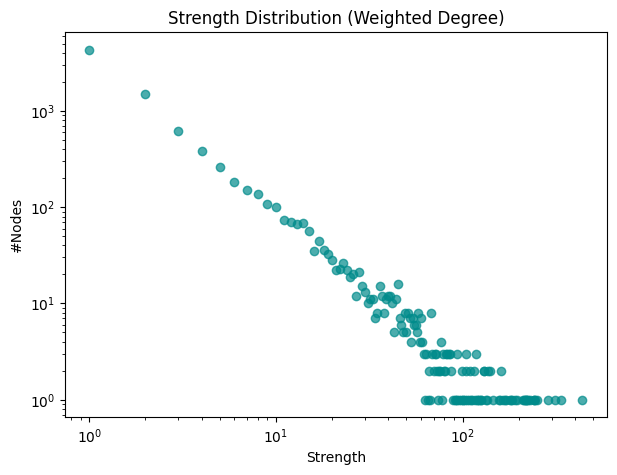

In [ ]:
from collections import Counter

strengths = [s for _, s in G.degree(weight="weight") if s > 0]

count = Counter(strengths)

plt.figure(figsize=(7,5))
plt.scatter(count.keys(), count.values(), color="darkcyan", alpha=0.7)
plt.xscale("log")
plt.yscale("log")
plt.title("Strength Distribution (Weighted Degree)")
plt.xlabel("Strength")
plt.ylabel("#Nodes")
plt.show()


Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit


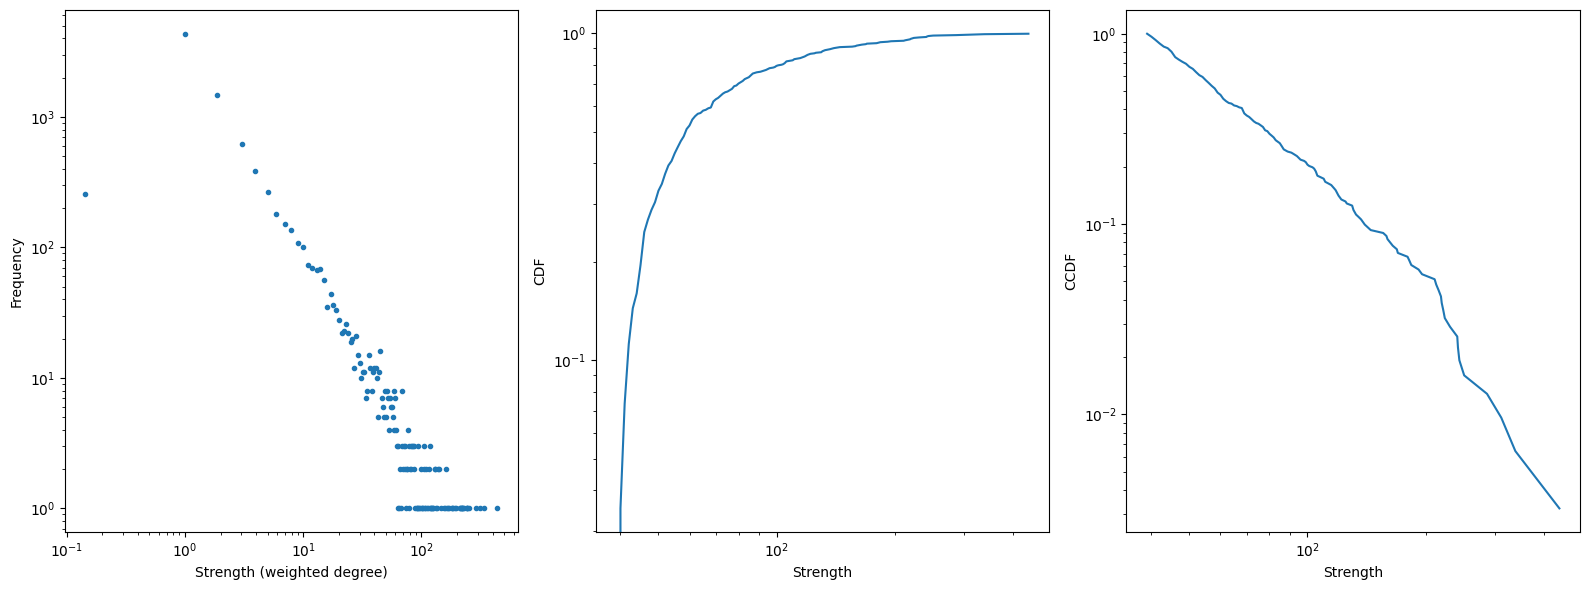

In [13]:
plot_strength_dist(G)

In [ ]:
strength = dict(G.degree(weight="weight"))

clust_w = nx.clustering(G, weight="weight")   

x = []
y = []
for n, s in strength.items():
    x.append(s)
    y.append(clust_w.get(n, 0.0)) 


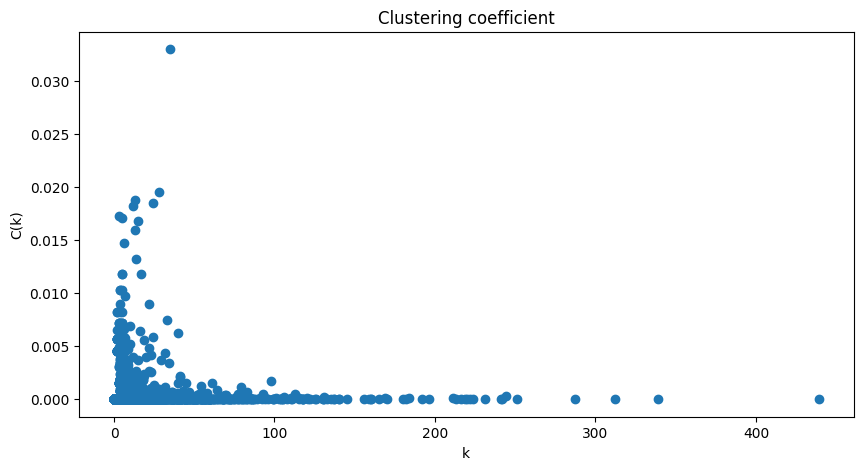

In [15]:
plt.figure(figsize=(10,5))
plt.scatter(x, y)

plt.xlabel("k")
plt.ylabel("C(k)")
plt.title("Clustering coefficient")
plt.show()

### Synthetic networks comparison

In [16]:
(G.number_of_nodes(), math.log(len(G)))

(9120, 9.118225083068378)

In [18]:
net_char_weighted(G)

{'node_num': 9120,
 'edges_num': 11857,
 'directed': False,
 'max_edges_num': 41582640.0,
 'self_loops_num': 0,
 'average_degree': 2.600219298245614,
 'highest_degree': 110,
 'lowest_degree': 0,
 'density': 0.0002851430308417166,
 'num_connected_components': 473,
 'size_biggest_component': 7891,
 'triangles_number_unweighted': 2187,
 'avg_clustering_coefficient_unweighted': 0.016672509589659767,
 'assortativity_unweighted': -0.3383524475247089,
 'total_weight': 28464.0,
 'average_strength': 6.242105263157895,
 'highest_strength': 439,
 'lowest_strength': 0,
 'avg_clustering_coefficient_weighted': 0.00013011366635970142,
 'assortativity_weighted_by_edge': -0.2142666750100017}

In [ ]:
p = nx.density(G)

er = nx.fast_gnp_random_graph(G.number_of_nodes(), p=p, seed=42, directed=False)

er_char = net_char_weighted(er)
er_char


{'node_num': 9120,
 'edges_num': 11901,
 'directed': False,
 'max_edges_num': 41582640.0,
 'self_loops_num': 0,
 'average_degree': 2.6098684210526315,
 'highest_degree': 10,
 'lowest_degree': 0,
 'density': 0.0002862011647168145,
 'num_connected_components': 755,
 'size_biggest_component': 8245,
 'triangles_number_unweighted': 6,
 'avg_clustering_coefficient_unweighted': 0.0002610693400167084,
 'assortativity_unweighted': -0.005927563487507611,
 'total_weight': 11901.0,
 'average_strength': 2.6098684210526315,
 'highest_strength': 10,
 'lowest_strength': 0,
 'avg_clustering_coefficient_weighted': 0.0002610693400167084,
 'assortativity_weighted_by_edge': -0.005927563487507611}

In [ ]:
ba = nx.barabasi_albert_graph(G.number_of_nodes(), 6, seed=42)

ba_char = net_char_weighted(ba)
ba_char


{'node_num': 9120,
 'edges_num': 54684,
 'directed': False,
 'max_edges_num': 41582640.0,
 'self_loops_num': 0,
 'average_degree': 11.992105263157894,
 'highest_degree': 396,
 'lowest_degree': 6,
 'density': 0.001315068018769371,
 'num_connected_components': 1,
 'size_biggest_component': 9120,
 'triangles_number_unweighted': 11070,
 'avg_clustering_coefficient_unweighted': 0.009237008663231596,
 'assortativity_unweighted': -0.0290511503343901,
 'total_weight': 54684.0,
 'average_strength': 11.992105263157894,
 'highest_strength': 396,
 'lowest_strength': 6,
 'avg_clustering_coefficient_weighted': 0.009237008663231596,
 'assortativity_weighted_by_edge': -0.0290511503343901}

In [ ]:
ws = nx.watts_strogatz_graph(G.number_of_nodes(), k=12, p=0.2, seed=42)

ws_char = net_char_weighted(ws)
ws_char


{'node_num': 9120,
 'edges_num': 54720,
 'directed': False,
 'max_edges_num': 41582640.0,
 'self_loops_num': 0,
 'average_degree': 12.0,
 'highest_degree': 19,
 'lowest_degree': 7,
 'density': 0.0013159337646671784,
 'num_connected_components': 1,
 'size_biggest_component': 9120,
 'triangles_number_unweighted': 209415,
 'avg_clustering_coefficient_unweighted': 0.3515298887086161,
 'assortativity_unweighted': -0.018940466370124046,
 'total_weight': 54720.0,
 'average_strength': 12.0,
 'highest_strength': 19,
 'lowest_strength': 7,
 'avg_clustering_coefficient_weighted': 0.3515298887086161,
 'assortativity_weighted_by_edge': -0.018940466370124046}

In [ ]:
deg_seq = [d for _, d in G.degree()]

cm = nx.configuration_model(deg_seq, seed=42)

cm = nx.Graph(cm)

cm.remove_edges_from(nx.selfloop_edges(cm))

cm_char = net_char_weighted(cm)
cm_char


{'node_num': 9120,
 'edges_num': 11796,
 'directed': False,
 'max_edges_num': 41582640.0,
 'self_loops_num': 0,
 'average_degree': 2.586842105263158,
 'highest_degree': 106,
 'lowest_degree': 0,
 'density': 0.0002836760725148764,
 'num_connected_components': 1228,
 'size_biggest_component': 6789,
 'triangles_number_unweighted': 1221,
 'avg_clustering_coefficient_unweighted': 0.001728120408092263,
 'assortativity_unweighted': -0.0030185021384213514,
 'total_weight': 11796.0,
 'average_strength': 2.586842105263158,
 'highest_strength': 106,
 'lowest_strength': 0,
 'avg_clustering_coefficient_weighted': 0.001728120408092263,
 'assortativity_weighted_by_edge': -0.0030185021384213514}

In [23]:
networks = {'Artists Graph' : G,
            'Erdős-Rényi' : er,
            'Barabási–Albert' : ba,
            'Watts Strogatz' : ws,
            'Configuration Model' : cm
}

### Degree analysis - comparison

In [24]:
def degree_distribution_plot(gaph_dict):
    fig = plt.figure(figsize=(16,8))
    labels = []
    for name, graph in gaph_dict.items():
      degrees = graph.degree()
      values = sorted(set([value for key, value in degrees]))
      hist = [[value for key, value in degrees].count(x) for x in values]
      labels.append(name)

      plt.loglog(values, hist, 'o-')

      fontsize = 15

    plt.yticks(fontsize=fontsize, alpha=1)
    plt.xlabel("Degree", fontsize=fontsize)
    plt.ylabel("Number of nodes", fontsize=fontsize)
    plt.title("Degree Distribution", fontsize=fontsize)
    plt.legend(labels, fontsize=fontsize)
    plt.grid(axis='both', alpha=.3)
    plt.xlim([0, 2*10**2])

    plt.show()

C:\Users\acast\AppData\Local\Temp\ipykernel_7508\736747180.py:20: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim([0, 2*10**2])


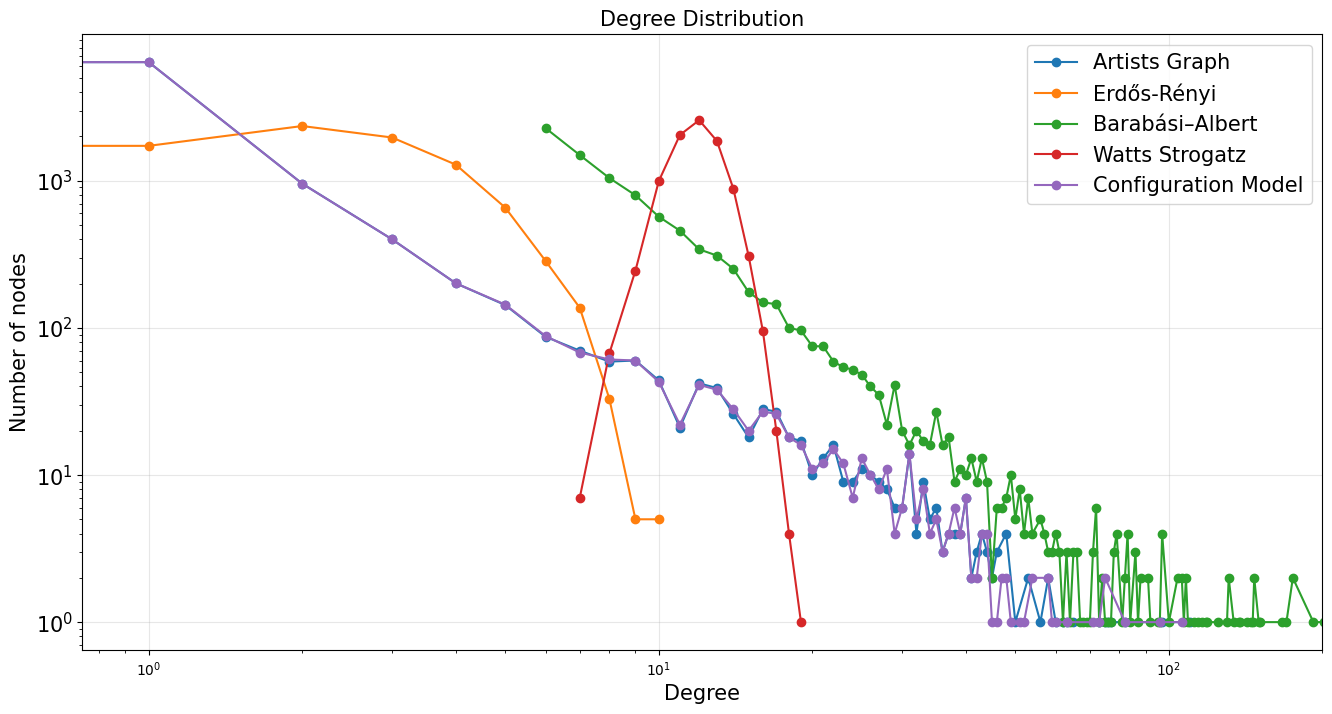

In [25]:
degree_distribution_plot(networks)

In [27]:
for net, graph in networks.items():
    hubs, not_hubs = hub_net_weighted(graph, threshold=80, weight_attr="weight")
    print(f"Hubs in {net}: {len(hubs)}")


Hubs in Artists Graph: 93
Hubs in Erdős-Rényi: 0
Hubs in Barabási–Albert: 66
Hubs in Watts Strogatz: 0
Hubs in Configuration Model: 3


In [ ]:
strength = dict(G.degree(weight="weight"))

top20 = sorted(strength.items(), key=lambda item: item[1], reverse=True)[:20]

top20_info = []
for node, str_val in top20:
    name = G.nodes[node].get('artist_name', node)   # usa 'artist_name' se presente
    genre = G.nodes[node].get('artist_first_genre', 'unknown')
    top20_info.append((name, str_val, genre))

top20_info


[('Karsten Glück', 439, "children's music"),
 ('RBD', 339, 'latin pop'),
 ('Dance Fruits Music', 312, 'deep house'),
 ('Die drei ???', 287, 'genre_not_available'),
 ('Maverick City Music', 251, 'worship'),
 ('Dímelo Flow', 244, 'reggaeton'),
 ('David Guetta', 242, 'edm'),
 ('Dreamville', 241, 'genre_not_available'),
 ('Max Richter', 231, 'neoclassical'),
 ('Lofi Fruits Music', 224, 'lo-fi hip hop'),
 ('Chill Fruits Music', 222, 'lo-fi hip hop'),
 ('Simone Sommerland', 220, "children's music"),
 ('Die Kita-Frösche', 219, "children's music"),
 ('Andreas Eschbach', 216, 'genre_not_available'),
 ('Wolfgang Amadeus Mozart', 213, 'classical'),
 ('Boy Wonder CF', 211, 'reggaeton'),
 ("Gigi D'Agostino", 196, 'eurodance'),
 ('White 2115', 192, 'genre_not_available'),
 ('DJ Khaled', 184, 'genre_not_available'),
 ('Shoreline Mafia', 182, 'genre_not_available')]

In [ ]:
def hub_net_weighted(G, threshold, weight_attr="weight"):
    strength = dict(G.degree(weight=weight_attr))
    
    hubs = [
        G.nodes[node].get("artist_name", node)
        for node, s in strength.items() if s >= threshold
    ]
    not_hubs = [
        G.nodes[node].get("artist_name", node)
        for node, s in strength.items() if s < threshold
    ]
    return hubs, not_hubs


In [ ]:
hubs, not_hubs = hub_net_weighted(G, threshold=70, weight_attr="weight")

print(hubs, len(hubs))

['Future', 'Justin Bieber', 'Kanye West', 'J Balvin', 'Chris Brown', 'David Guetta', 'Calvin Harris', 'Arijit Singh', 'Metro Boomin', 'Die drei ???', 'Andreas Eschbach', 'Hazel Brugger', 'Disney', 'Alan Walker', 'Pop Smoke', 'Macklemore', 'Gorillaz', 'Brent Faiyaz', 'DJ Khaled', 'Grupo Firme', 'Clean Bandit', 'MC Ryan SP', 'Mark Ronson', 'Rae Sremmurd', 'Original Broadway Cast of Hamilton', 'Mustard', 'Capital Bra', 'Filipe Ret', 'Cheat Codes', 'bbno$', 'Hillsong Worship', 'DJ Nelson', 'Seeb', 'MF DOOM', 'Chandler Moore', 'Mainstreet', 'Sam Feldt', 'Ferrugem', 'Dadju', 'Dímelo Flow', 'Dream Supplier', 'Shiloh Dynasty', 'Continental', 'Roxette', 'Per Gessle', 'Internet Money', 'Bethel Music', 'Johann Sebastian Bach', 'Annie Lennox', 'White Noise Baby Sleep', 'Mike WiLL Made-It', 'Pineapple StormTv', 'Salmo', 'Eyedress', "Gigi D'Agostino", 'Lento Violento', 'Harris Jayaraj', 'G. V. Prakash', 'Karsten Glück', 'Simone Sommerland', 'Die Kita-Frösche', 'Tulsi Kumar', 'Supernova Ent', 'Andrea

### Ego-graph for node with highest degree

In [ ]:
def ego_by_name(G, artist_name, radius=1, weight_attr=None):
    node_id = next(
        (n for n, d in G.nodes(data=True)
         if d.get("artist_name", "").lower() == artist_name.lower()),
        None
    )
    if node_id is None:
        return None
    
    return nx.ego_graph(G, node_id, radius=radius, distance=weight_attr)


In [37]:
ego = ego_by_name(G, "Stephanie Beatriz")

In [38]:
len(ego)

38

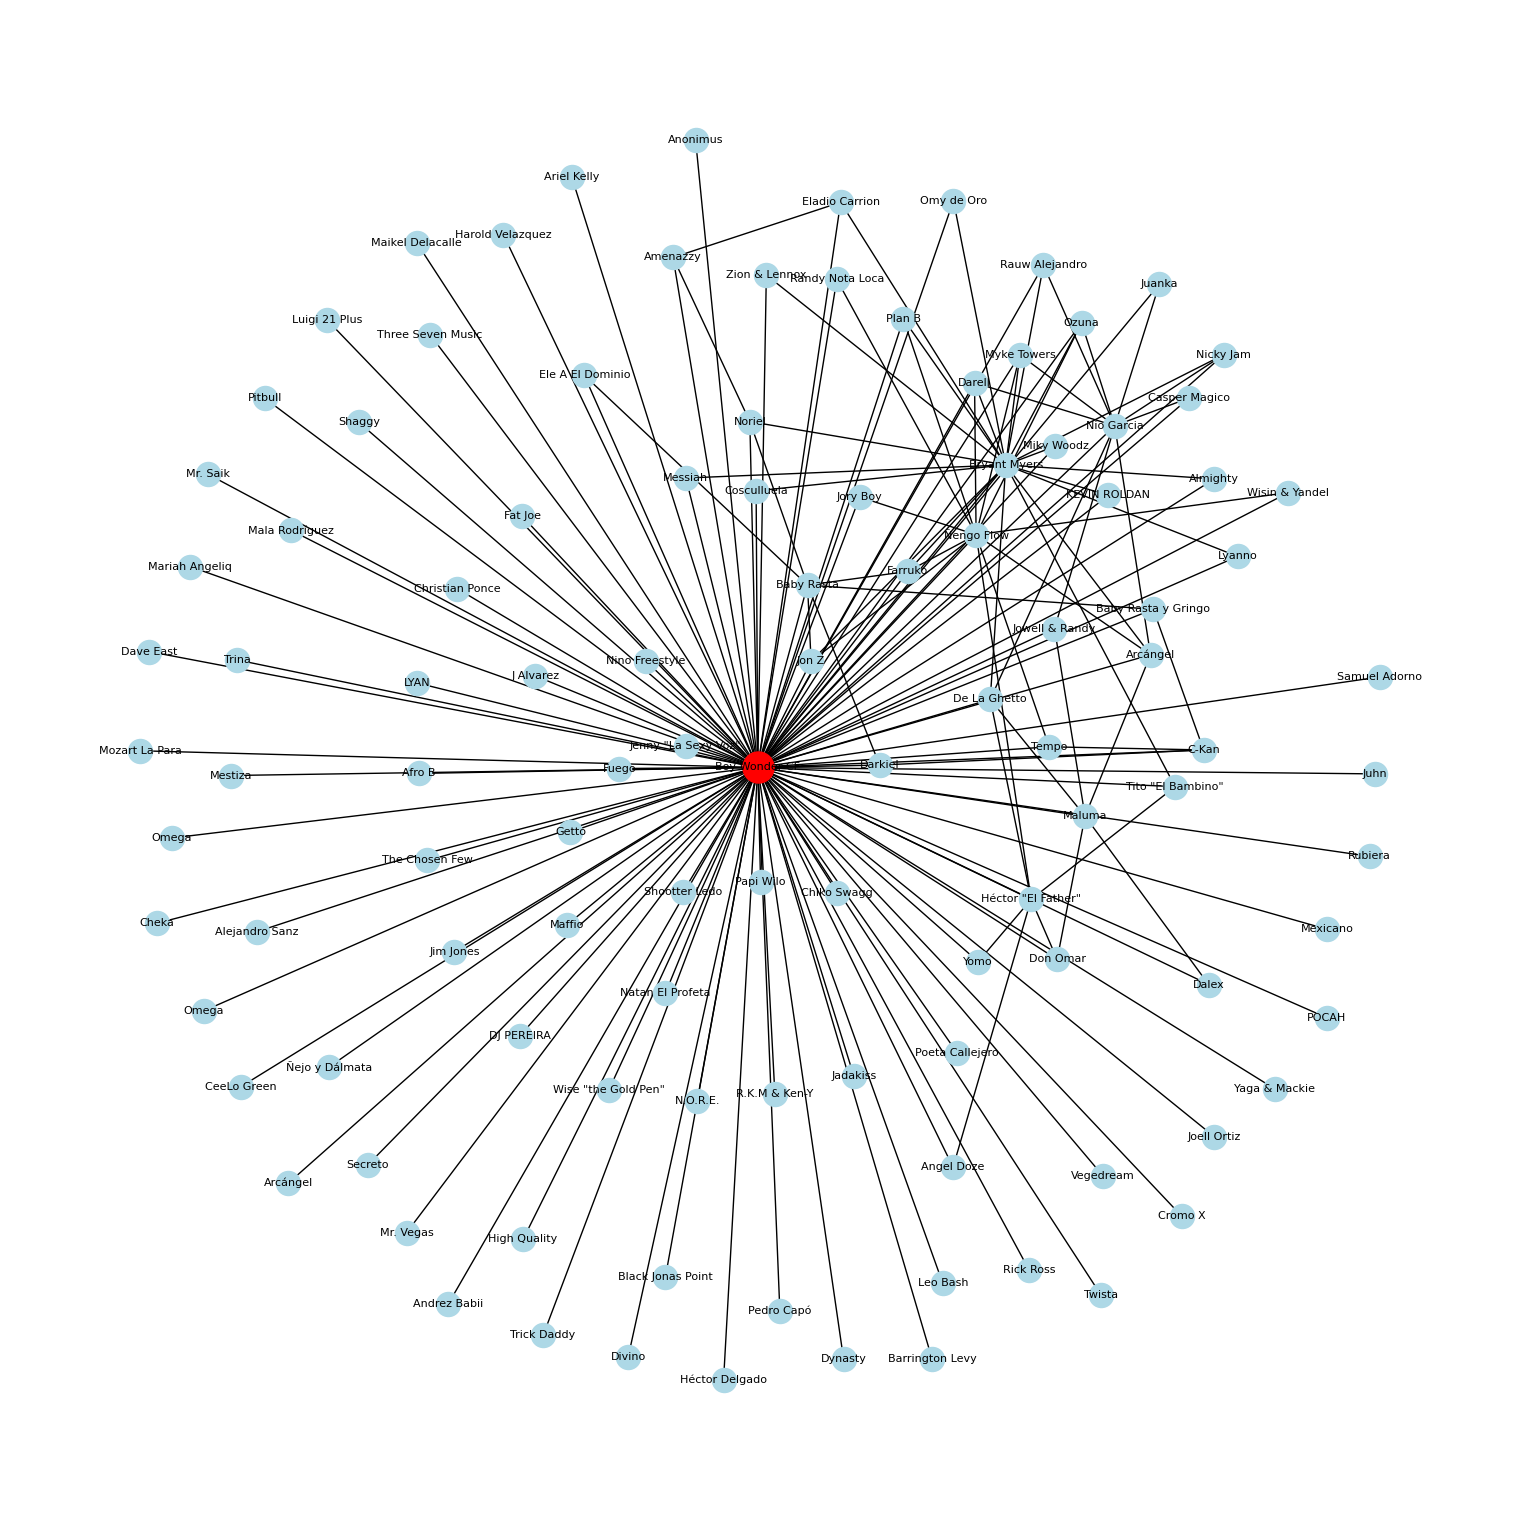

In [ ]:
from operator import itemgetter

node_and_degree = G.degree()
(largest_hub, degree) = sorted(node_and_degree, key=itemgetter(1))[-1]

hub_ego = nx.ego_graph(G, largest_hub)

plt.figure(figsize=(15,15))
pos = nx.spring_layout(hub_ego, seed=42)

labels = {n: d.get("artist_name", n) for n, d in hub_ego.nodes(data=True)}

nx.draw(hub_ego, pos, labels=labels, node_color="lightblue", node_size=300,
        font_size=8, with_labels=True)
nx.draw_networkx_nodes(hub_ego, pos, nodelist=[largest_hub],
                       node_size=500, node_color="red")

plt.show()

nx.write_graphml(hub_ego, "ego_net.graphml")


### Connected Components

In [39]:
def connected_components_info(G, weight_attr="weight"):
    comps = sorted(nx.connected_components(G), key=len, reverse=True)
    info = []
    for comp in comps:
        subG = G.subgraph(comp)
        # numero nodi e archi
        n, m = subG.number_of_nodes(), subG.number_of_edges()
        # somma pesi
        total_weight = sum(d.get(weight_attr, 1.0) for _, _, d in subG.edges(data=True))
        info.append({"size": n, "edges": m, "total_weight": total_weight})
    return comps, info

connected_components_G, info_G = connected_components_info(G)
connected_components_cm, info_cm = connected_components_info(cm)


In [40]:
len_components_G = [len(comp) for comp in connected_components_G ]
set(len_components_G)

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 26,
 29,
 7891}

In [41]:
len_components_cm = [len(comp) for comp in connected_components_cm ]
set(len_components_cm)

{1, 2, 3, 4, 5, 6, 8, 6789}

In [42]:
networks_giant_components = {net : graph.subgraph(sorted(list(nx.connected_components(graph)), key=len, reverse = True)[0])
                           for net, graph in networks.items()}


In [43]:
networks_giant_components.keys()

dict_keys(['Artists Graph', 'Erdős-Rényi', 'Barabási–Albert', 'Watts Strogatz', 'Configuration Model'])

### Approximate Path length analysis

In [ ]:
import random
from statistics import mean, stdev

def approximate_shortest_path_length(
    graph,
    num_internal_samples=200,
    num_external_samples=100,
    seed=42,
    weight_attr=None
):
    nodes = list(graph.nodes())
    external_samples = []

    for _ in range(num_external_samples):
        lengths = []
        for _ in range(num_internal_samples):
            random.seed(seed)
            n1, n2 = random.choices(nodes, k=2)
            try:
                length = nx.shortest_path_length(
                    graph, source=n1, target=n2, weight=weight_attr
                )
                lengths.append(length)
            except nx.NetworkXNoPath:
                continue
            seed += 1
        if lengths:
            external_samples.append(mean(lengths))

    if not external_samples:
        return None, None

    return mean(external_samples), stdev(external_samples)


In [ ]:
for net, biggest_component in networks_giant_components.items():
    print(f"{net} - Giant Component", end="\n\n")

    avg_len, std_len = approximate_shortest_path_length(
        biggest_component, seed=42, weight_attr="weight"
    )
    print("Approximated average shortest path: ", (avg_len, std_len), end="\n\n")

    diam = nx.approximation.diameter(
        biggest_component, seed=42, usebounds=True, weight="weight"
    )
    print("2-sweep approximated diameter: ", diam, end="\n\n")


Artists Graph - Giant Component

Approximated average shortest path:  (10.93585, 0.6993225636141008)



TypeError: diameter() got an unexpected keyword argument 'usebounds'

### Centrality analysis

In [ ]:
def plot_barplot(ranks, n=10, method_name="Centrality"):
    if not ranks:
        print("Lista vuota: nessun nodo da plottare.")
        return [], []

    top = ranks[:n]
    top_names = [t[0] for t in top]
    top_scores = [t[1] for t in top]

    plt.figure(figsize=(14,5))
    x_pos = np.arange(len(top_names))
    plt.bar(x_pos, top_scores, color="darkcyan", alpha=0.8)
    plt.xlabel("Artists", fontsize=12)
    plt.xticks(x_pos, top_names, rotation=30, fontsize=10, ha="right")
    plt.ylabel(f"{method_name} Score", fontsize=12)
    plt.title(f"Top {n} nodes by {method_name}", fontsize=14)
    plt.grid(axis="y", alpha=0.3)

    plt.show()
    return top_names, top_scores


In [49]:
degrees = dict(G.degree())
ranks_degrees = [(key, value) for key, value in sorted(degrees.items(), key=lambda item: -item[1])]

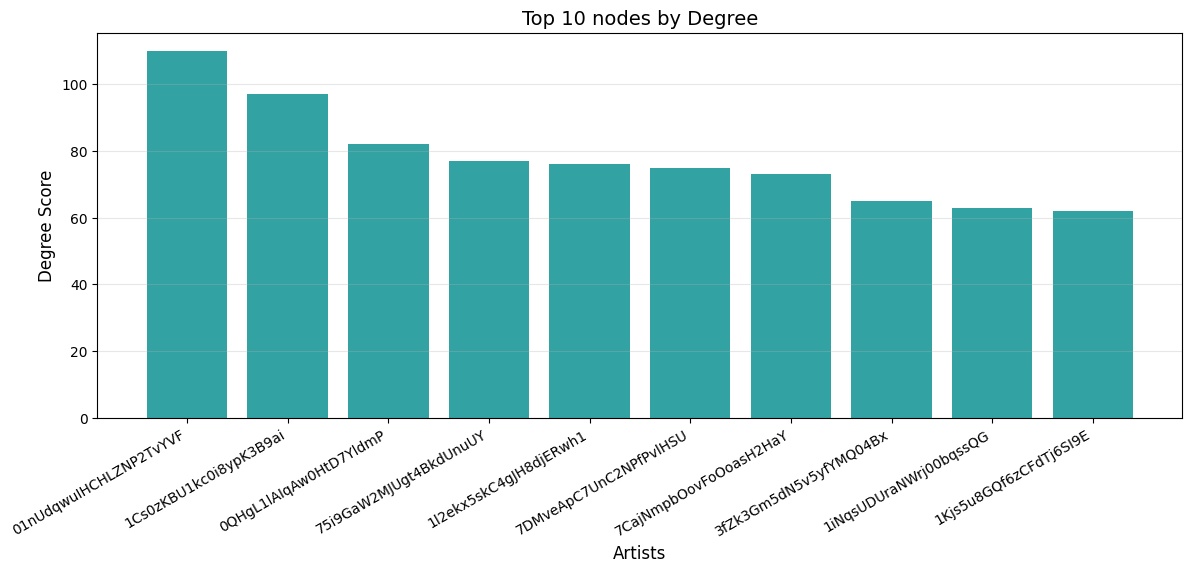

['reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton']

In [50]:
names, scores = plot_barplot(ranks_degrees, 10 , 'Degree')
[G.nodes[names[0]]['artist_first_genre'] for name in names]

In [51]:
pagerank = nx.pagerank(G)
ranks_pagerank = [(key, value) for key, value in sorted(pagerank.items(), key=lambda item: -item[1])]

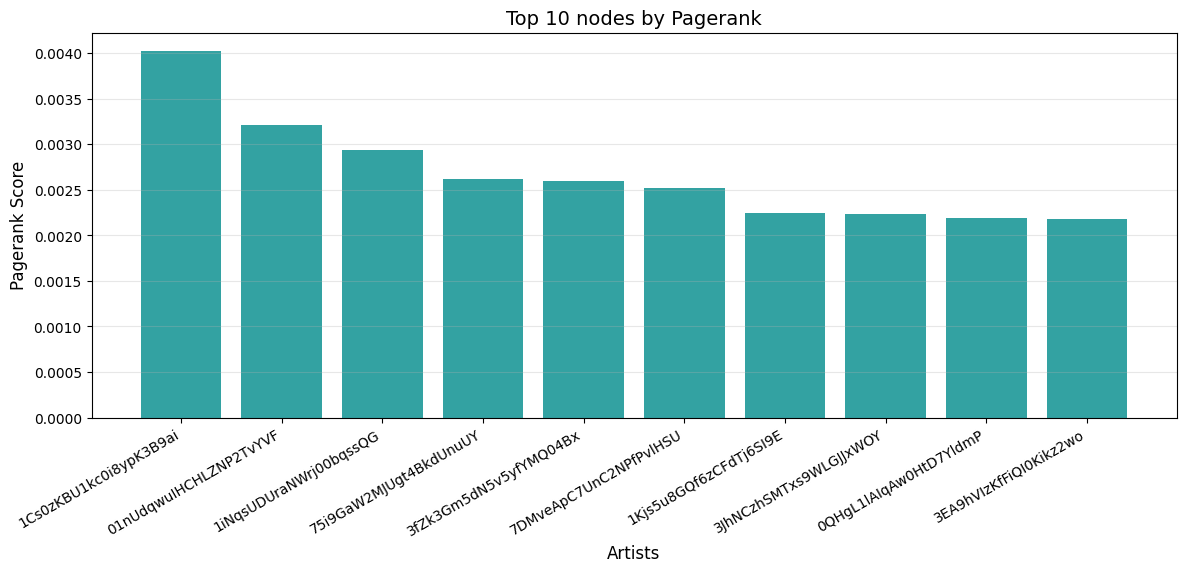

['edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm']

In [52]:
names, scores = plot_barplot(ranks_pagerank, 10, 'Pagerank')
[G.nodes[names[0]]['artist_first_genre'] for name in names]

In [53]:
eigen = nx.eigenvector_centrality(G)
ranks_ev = [(key, value) for key, value in sorted(eigen.items(), key=lambda item: -item[1])]

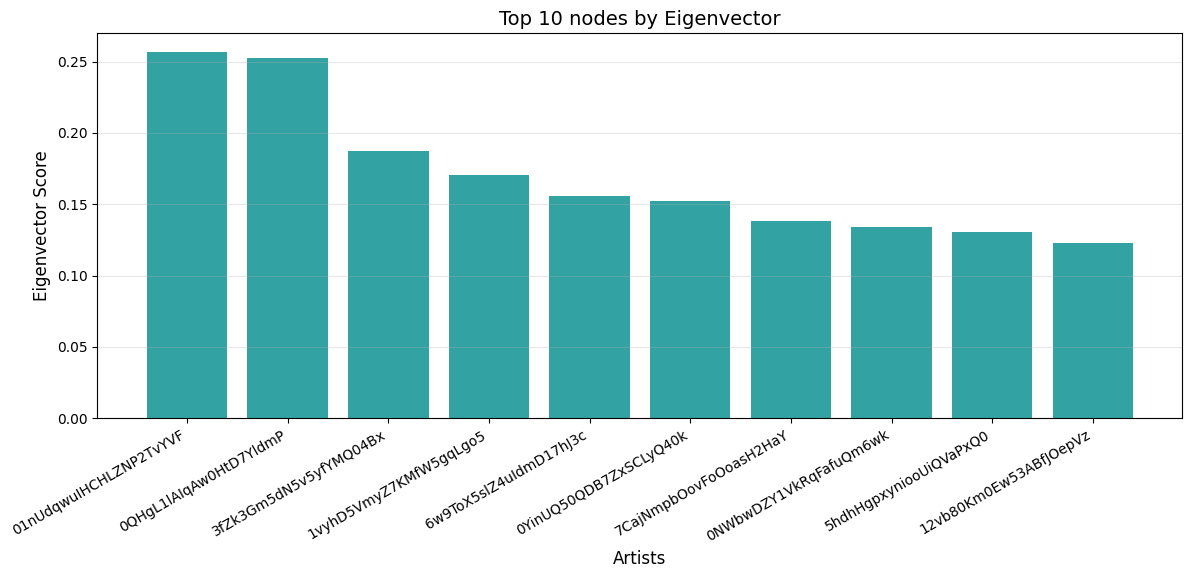

['reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton',
 'reggaeton']

In [54]:
names, scores = plot_barplot(ranks_ev, 10, 'Eigenvector')
[G.nodes[names[0]]['artist_first_genre'] for name in names]

In [55]:
harmonic = nx.harmonic_centrality(G)
ranks_harmonic = [(key, value) for key, value in sorted(harmonic.items(), key=lambda item: -item[1])]

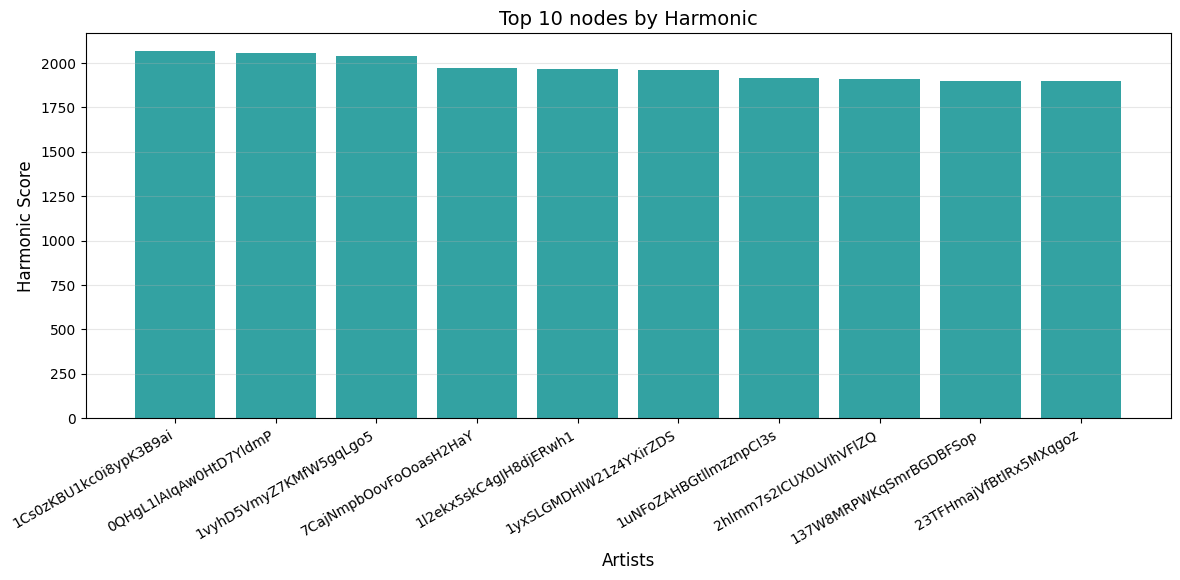

['edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm']

In [56]:
names, scores = plot_barplot(ranks_harmonic, 10, 'Harmonic')
[G.nodes[names[0]]['artist_first_genre'] for name in names]

In [57]:
closeness = nx.closeness_centrality(G)
ranks_closeness = [(key, value) for key, value in sorted(closeness.items(), key=lambda item: -item[1])]

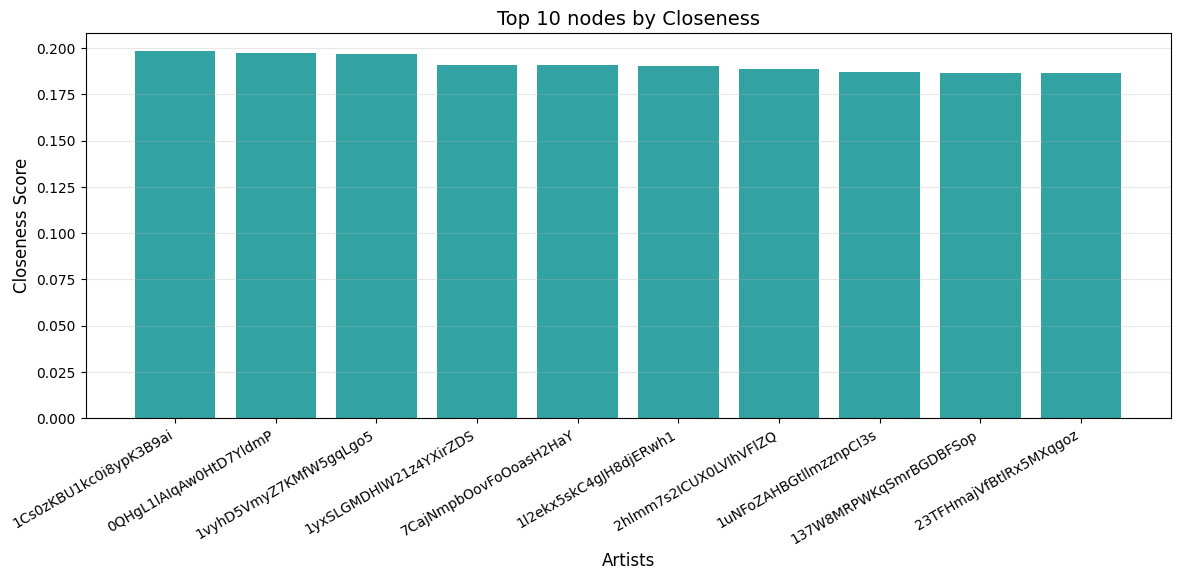

['edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm', 'edm']

In [58]:
names, scores = plot_barplot(ranks_closeness, 10, 'Closeness')
[G.nodes[names[0]]['artist_first_genre'] for name in names]

### Assortativity analysis

In [59]:
knn = nx.average_degree_connectivity(G)
knn = dict(sorted(knn.items()))

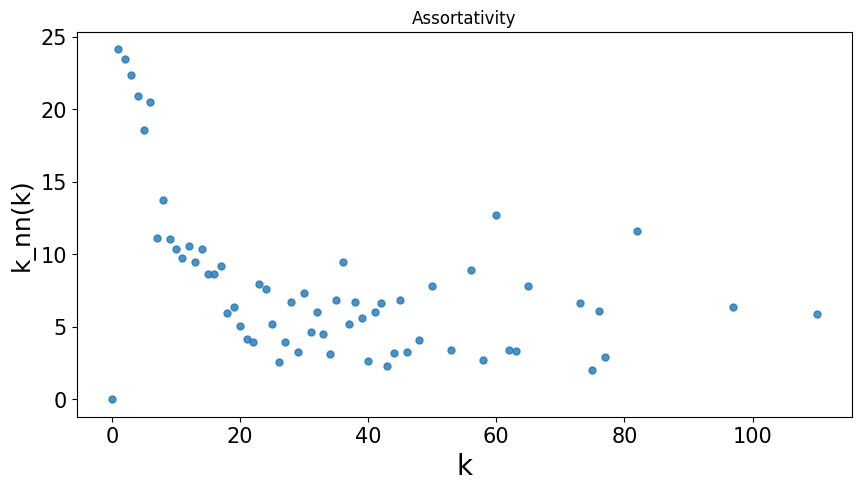

In [ ]:

plt.figure(figsize=(10,5))

plt.plot(list(knn.keys()), list(knn.values()), '.', ms=10, alpha=0.8)
plt.xlabel("k", fontsize=20)
plt.ylabel("k_nn(k)",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Assortativity")
plt.show()

In [61]:
n_followers = [[G.nodes[node]['artist_n_followers']] for node in list(G.nodes)]

In [62]:
nodes_bins = KBinsDiscretizer(n_bins=250, encode = 'ordinal').fit_transform(n_followers)

In [63]:
for node, bin_label in zip(list(G.nodes), nodes_bins):
  G.nodes[node]['bin_follower'] = int(bin_label)

C:\Users\acast\AppData\Local\Temp\ipykernel_7508\2225716867.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  G.nodes[node]['bin_follower'] = int(bin_label)


In [64]:
print('Assorativity for main genre: ' , nx.attribute_assortativity_coefficient(G, 'main_genre'))
print('Assorativity for pupularity: ' , nx.attribute_assortativity_coefficient(G, 'artist_popularity'))
print('Assorativity for num_followers: ' , nx.attribute_assortativity_coefficient(G, 'bin_follower'))

Assorativity for main genre:  nan
Assorativity for pupularity:  -0.00258379923109798
Assorativity for num_followers:  0.0024326617889043876


C:\Users\acast\anaconda3\Lib\site-packages\networkx\algorithms\assortativity\correlation.py:282: RuntimeWarning: invalid value encountered in scalar divide
  r = (t - s) / (1 - s)
